In [1]:
import os
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import gc
import matplotlib.patches as mpatches
from scipy.stats import pearsonr, spearmanr
from models.resnet import *

In [2]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
torch.manual_seed(551)
torch.cuda.manual_seed_all(551)
np.random.seed(551)

In [ ]:
import argparse

parser = argparse.ArgumentParser()

parser.set_defaults(crop_size=224, lr=0.0001, test_size=0.2, optimizer='Adam')

parser.add_argument('--test', help='run for test (True or False)')

parser.add_argument('--crop_size', help='size to crop out')
parser.add_argument('--epoch', required=True, help='num of epochs')
parser.add_argument('--batch_size', required=True, help='batch size')
parser.add_argument('--lr', help='learning rate')
parser.add_argument('--optimizer', help='optimizer: Adam or AdamW')
parser.add_argument('--test_size', help='size ratio of test dataset ( < 1)')
parser.add_argument('-l', '--filename_l', required=True, help='loss plot file name')
parser.add_argument('-c', '--filename_c', required=True, help='correlation plot file name')

args, unknown = parser.parse_known_args()

args.test = True if args.test=='True' else False

crop_size = int(args.crop_size)
test_size = float(args.test_size)
config_dict = dict(n_epoch=int(args.epoch), batch_size=int(args.batch_size), lr=float(args.lr))
optimizer = args.optimizer
filename_l = args.filename_l + '.png'
filename_c = args.filename_c + '.png'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [5]:
crop_size = 170
test_size = 0.2
config_dict = dict(n_epoch=3, batch_size=16, lr=0.0001)
optimizer = 'AdamW'
# filename_l = 
# filename_c = 
test = True

In [6]:
def load_data(crop_size=224, test=False):
    df = pd.read_csv('labels/admin_NeuroQuant.csv', index_col=0)['Cerebral WM Hypointensities* Total Percent Of Icv']
    if test:
        df.drop(df.index[64:], inplace=True)
    filenames = df.index
    base = 'input_nifti_resized/'
    images = []
        
    for i, index in enumerate(tqdm(filenames)):
        file_name = base + index + '.nii.gz'
        img = nib.load(file_name)
        img = img.get_fdata()
            
        # center crop
        d, h, w = img.shape
        margin_h = (h - crop_size) // 2
        margin_w = (w - crop_size) // 2
        img = img[d-crop_size:, margin_h:margin_h+crop_size, margin_w:margin_w+crop_size]
            
        # normalizing
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
        img = img.reshape((1, crop_size, crop_size, crop_size))
        images.append(img)
        
    return images, df

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, data_loaded=True):
        self.X = X
        self.y = y.values
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = np.array([self.y[idx]]).astype('float16')
        return [image, label]

In [8]:
def run_train(model, train_loader, config_dict, optimizer='Adam'):
    model.train()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    assert optimizer=='Adam' or optimizer=='AdamW', "optimizer should be Adam or AdamW"
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config_dict['lr'])
    elif optimizer =='AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config_dict['lr'])
    
    total_loss = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()
        output = model(inputs)
        pred = output.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        
        mae_loss = criterion1(output, labels)
        mse_loss = criterion2(output, labels)
        mae_loss.backward()
        
        optimizer.step()
        total_loss += mae_loss.data.item()
        
        train_img = inputs.cpu().numpy()
        
        gc.collect()
        torch.cuda.empty_cache()
        
    return train_img, pred, truth, total_loss

In [9]:
def run_valid(model, valid_loader):
    model.eval()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    total_loss = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
#             print(f'Valid_Prediction : {pred}')
#             print(f'Valid_Truth : {truth}')

            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
            total_loss += mae_loss.data.item()

            valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, total_loss

In [10]:
def predict(model, data_loader, file_name):
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
    
    _min = min(np.min(preds), np.min(truths))
    _max = max(np.max(preds), np.max(truths))
    
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='r')
    plt.scatter(truths, preds, c='b')
    plt.axis('square')
    plt.ylabel('prediction'); plt.xlabel('ground truth')
    
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.savefig(file_name)
    plt.show()
    plt.close()
    
    return preds, truths

In [11]:
X, y = load_data(crop_size=crop_size, test=test)
dataset = NeckDataset(X, y)

train, valid = train_test_split(dataset, test_size=test_size)
train_loader = DataLoader(train, batch_size=config_dict['batch_size'], shuffle=True)
valid_loader = DataLoader(valid, batch_size=config_dict['batch_size'], shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.57it/s]


In [18]:
resnet = resnet26(in_channels=1, num_classes=1)  # resnet26
model = nn.DataParallel(resnet)  # to use all available GPUs
model = model.cuda()

# # to use specific GPU
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# model = nn.DataParallel(resnet, device_ids=[1])
# model = model.to(device)

# Epoch 1 / 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


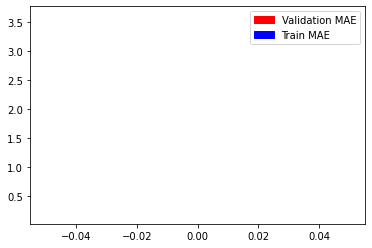

# Epoch 2 / 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


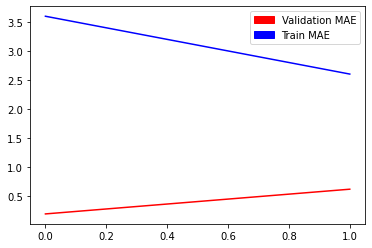

# Epoch 3 / 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


NameError: name 'filename_l' is not defined

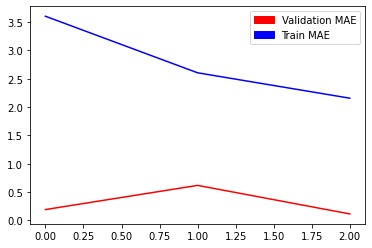

In [19]:
train_values = {'pred': [], 'truth': [], 'loss': []}
valid_values = {'pred': [], 'truth': [], 'loss': []}

start = time.time()
for epoch in range(config_dict['n_epoch']):
    print('# Epoch %d / %d'%(epoch + 1, config_dict['n_epoch']));
    train_img, pred_t, truth_t, loss_t = run_train(model, train_loader, config_dict, optimizer=optimizer)
    valid_img, pred_v, truth_v, loss_v = run_valid(model, valid_loader)

    train_values['pred'] += [pred_t]
    train_values['truth'] += [truth_t]
    train_values['loss'] += [loss_t]
    valid_values['pred'] += [pred_v]
    valid_values['truth'] += [truth_v]
    valid_values['loss'] += [loss_v]

    plt.plot(range(len(train_values['loss'])), train_values['loss'], 'b',
             range(len(valid_values['loss'])), valid_values['loss'], 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train MAE')
    red_patch = mpatches.Patch(color='red', label='Validation MAE')
    plt.legend(handles=[red_patch, blue_patch])
    if epoch == config_dict['n_epoch'] - 1:
        plt.savefig(filename_l)
    plt.show()
plt.close()
end = time.time()
exec_time = end - start
print("Total execution time: {}h {}mins".format(exec_time // 3600, exec_time // 60))

In [ ]:
data_loader = DataLoader(dataset, batch_size=config_dict['batch_size'], shuffle=False)
preds, truths = predict(model, data_loader, filename_c)
total_pearson, total_pearson_p = pearsonr(preds, truths)
total_spearman, total_spearman_p = spearmanr(preds, truths)
print("Pearson Correlation {:.6f} (p={:.3f})".format(total_pearson, total_pearson_p))
print("Spearman Correlation {:.6f} (p={:.3f})".format(total_spearman, total_spearman_p))